In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import cv2 as cv

import os, gc, csv

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
gpu = torch.cuda.is_available()
device = torch.device("cpu")

if gpu:
    print("use gpu")
    device = torch.device("cuda:0")

use gpu


In [4]:
def img_process(im):
    """
    do image processing in this function
    """
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
    
    return clahe.apply(im)

In [5]:
# BoostNet Dataset
# from SpineWeb dataset16
# link: http://spineweb.digitalimaginggroup.ca/spineweb/index.php?n=Main.Datasets

class BoostNetDataset(torch.utils.data.Dataset):
    def __init__(self, path, train=True):
        self.images = []
        self.labels = []
        
        if train:
            image_path = path + "/data/training/"
            names = csv.reader(open(path + "/labels/training/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r'))
        else:
            image_path = path + "/data/test/"
            names = csv.reader(open(path + "/labels/test/filenames.csv", 'r'))
            landmarks = csv.reader(open(path + "/labels/test/landmarks.csv", 'r'))
        
        for landmark_each_image in landmarks:
            coordinate_list = []
            for coordinate in landmark_each_image:
                coordinate_list.append(float(coordinate))

            self.labels.append(torch.Tensor(coordinate_list))

        for i, name in enumerate(names):
            origin_image = cv.imread(image_path + name[0], cv.COLOR_BGR2GRAY)
            
            processed_image = origin_image #img_process(origin_image)
            
            #resize
            target_height = 512
            target_width = 256
            image = np.zeros((target_height, target_width), np.uint8)
            cv.resize(processed_image, (target_width, target_height), image)

            image = np.reshape(image, (1, image.shape[0], image.shape[1]))

            image_tensor = torch.from_numpy(image).float()
            
            self.images.append(image_tensor)

        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        
        return image, label
    
    def __len__(self):
        return len(self.images)

In [6]:
from unet import UNet

res_unet = UNet(n_classes=136, in_channels=1, depth=4).to(device)

print(res_unet)

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (1): 

In [7]:
# define loss function
import torch.optim as optim

criterion = nn.MSELoss().to(device)

optimizer = optim.SGD(res_unet.parameters(), lr=0.08)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

In [8]:
# function to compute loss

def compute_loss(net, data_loader):
    loss_sum = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
                
            outputs = res_unet(images)
            loss = criterion(outputs.float(), labels.float()) 
            loss_sum += loss.item()
            
    return loss_sum / len(data_loader)

In [9]:
path = "E:/Workspace/AASCE2019/boostnet_labeldata"
train_data = BoostNetDataset(path, train=True)
test_data = BoostNetDataset(path, train=False)

batch = 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch,
                                         shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch,
                                         shuffle=True, num_workers=0)


print("number of batches(training): ", len(train_loader))
print("number of batches(testing): ", len(test_loader))

number of batches(training):  121
number of batches(testing):  32


In [10]:
epoch_num = 15

loss1 = []
loss2 = []

for epoch in range(epoch_num):
   
    for i, data in enumerate(train_loader):

        # get the inputs
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = res_unet(inputs)

        loss = criterion(outputs.float(), labels.float())
        
        loss.backward()
        optimizer.step()
        
    scheduler.step()    
    
    train_loss = compute_loss(res_unet, train_loader)
    loss1.append(train_loss)

    test_loss = compute_loss(res_unet, test_loader)
    loss2.append(test_loss)
    print("epoch number", epoch+1, "train_loss", train_loss, "test_loss", test_loss)

print('Finished Training')

C:\Users\wlgq\AppData\Local\conda\conda\envs\pt\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


epoch number 1 train_loss 0.17459782206815136 test_loss 0.17067789053544402
epoch number 2 train_loss 0.09191760562421862 test_loss 0.08884692308492959
epoch number 3 train_loss 0.03363108063840176 test_loss 0.03133136313408613
epoch number 4 train_loss 0.011846105725897 test_loss 0.010058526415377855
epoch number 5 train_loss 0.007337276629472444 test_loss 0.0060269662499194965
epoch number 6 train_loss 0.006041667747411354 test_loss 0.004822616683668457
epoch number 7 train_loss 0.005867593469529236 test_loss 0.0046429280992015265
epoch number 8 train_loss 0.0056256982132269085 test_loss 0.00451597958090133
epoch number 9 train_loss 0.005693410072006162 test_loss 0.0044980141101405025
epoch number 10 train_loss 0.005405695650010747 test_loss 0.004419972494360991
epoch number 11 train_loss 0.005242760137323875 test_loss 0.004331060488766525
epoch number 12 train_loss 0.005256963034606855 test_loss 0.004360156184702646
epoch number 13 train_loss 0.005272260281134181 test_loss 0.0043168

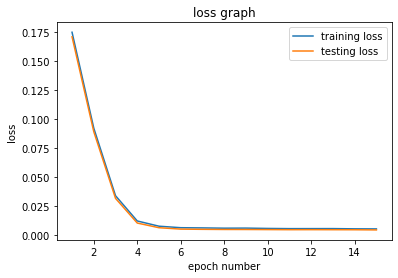

In [11]:
x = range(1, epoch_num+1)

plt.plot(x, loss1, label="training loss")
plt.plot(x, loss2, label="testing loss")
plt.xlabel("epoch number")
#plt.xticks(np.linspace(1,epoch_num,epoch_num))
plt.ylabel("loss")
plt.title("loss graph")
plt.legend()
#plt.savefig("./coordinate-regression-loss.jpg")
plt.show()

In [12]:
torch.save(res_unet, 'E:/Workspace/ke30_u7_AASCE2019/unet_mean.pth')

In [ ]:
def CVimshow2pltimshow(cv_img):
    """
    cv_img: [3, height, width], BGR, numpy array, int(0-255)
    """
    b,g,r = cv.split(cv_img)  
    plt_img = cv.merge([r,g,b]).astype(np.int)
    return plt_img

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 20)

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
batch, channel, height, width = images.shape

ret = res_unet(images.to(device))

batch_img = np.zeros((height, width * batch, 3), np.int)

for i in range(batch):
    sample = images[i].numpy().squeeze(0)
    sample_BGR = cv.cvtColor(sample, cv.COLOR_GRAY2BGR)

    label = labels[i]
    predict = ret[i]

    point_num = len(label) // 2
    for j in range(point_num):
        cv.circle(sample_BGR, (int(label[j] * width), int(label[j + point_num]* height)), 2, (255, 255, 0))
        cv.circle(sample_BGR, (int(predict[j] * width), int(predict[j + point_num]* height)), 2, (0, 0, 255))
        
    plt_img = CVimshow2pltimshow(sample_BGR)
    batch_img[:, i * width:(i+1) * width, :] = plt_img

In [ ]:
plt.imshow(batch_img)